In [27]:
%matplotlib inline

In [67]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
import pandas as pd

# Please implement the fit and predict methods of this class. You can add additional private methods
# by beginning them with two underscores. It may look like the __dummyPrivateMethod below.
# You can feel free to change any of the class attributes, as long as you do not change any of 
# the given function headers (they must take and return the same arguments), and as long as you
# don't change anything in the .visualize() method. 
class GaussianGenerativeModel:
    def __init__(self, isSharedCovariance=False):
        self.isSharedCovariance = isSharedCovariance
        self.sigma1 = None
        self.sigma2 = None
        self.sigma3 = None
        self.mu1 = None
        self.mu2 = None
        self.mu3 = None
        self.preds = None

    
    def __fruit_data(self):
        self.fruit = pd.read_csv("fruit.csv")
        self.X = self.fruit[["width","height"]]
        self.y = self.fruit["fruit"]

    
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        c1 = X[Y==0]
        c2 = X[Y==1]
        c3 = X[Y==2]
        self.mu1 = np.mean(c1,axis=0)
        self.mu2 = np.mean(c2,axis=0)
        self.mu3 = np.mean(c3,axis=0)
        if self.isSharedCovariance:
            self.sigma1 = np.cov(X.transpose())
            self.sigma2 = np.cov(X.transpose())
            self.sigma3 = np.cov(X.transpose())
        else:
            self.sigma1 = np.cov(c1.transpose())
            self.sigma2 = np.cov(c2.transpose())
            self.sigma3 = np.cov(c3.transpose())
        return self
    
    
    def predict(self, X_to_predict):

        p1 = multivariate_normal.pdf(X_to_predict, mean=self.mu1, cov=self.sigma1)
        p2 = multivariate_normal.pdf(X_to_predict, mean=self.mu2, cov=self.sigma2)
        p3 = multivariate_normal.pdf(X_to_predict, mean=self.mu3, cov=self.sigma3)
        self.preds = pd.DataFrame({"Class 1":p1, "Class 2": p2, "Class 3": p3})
               
        return np.argmax(np.array(self.preds),axis=1) 
    
    

    # Do not modify this method!
    def visualize(self, output_file, width=3, show_charts=True):
        X = self.X

        # Create a grid of points
        x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
        y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
        xx,yy = np.meshgrid(np.arange(x_min, x_max, .005), np.arange(y_min,
            y_max, .005))

        # Flatten the grid so the values match spec for self.predict
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        X_topredict = np.vstack((xx_flat,yy_flat)).T

        # Get the class predictions
        Y_hat = self.predict(X_topredict)
        Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

        cMap = c.ListedColormap(['r','b','g'])

        # Visualize them.
        plt.figure()
        plt.pcolormesh(xx,yy,Y_hat, cmap=cMap)
        plt.scatter(X[:, 0], X[:, 1], c=self.Y, cmap=cMap)
        plt.savefig(output_file)
        if show_charts:
            plt.show()


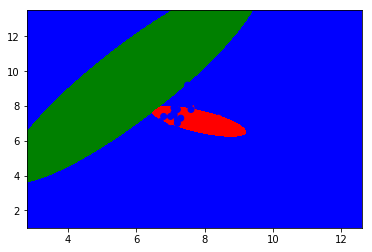

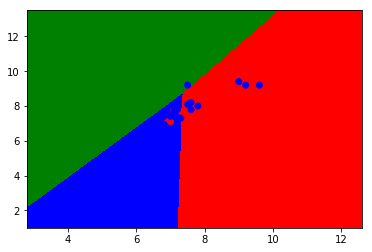

In [68]:
# Read from file and extract X and Y
df = pd.read_csv("fruit.csv")
X = df[['width', 'height']].values
Y = (df['fruit'] - 1).values

nb1 = GaussianGenerativeModel(isSharedCovariance=False)
nb1.fit(X,Y)
nb1.visualize("generative_result_separate_covariances.png")

nb2 = GaussianGenerativeModel(isSharedCovariance=True)
nb2.fit(X,Y)
nb2.visualize("generative_result_shared_covariances.png")

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from scipy.misc import logsumexp
import pandas as pd
from sklearn import preprocessing

# Please implement the fit and predict methods of this class. You can add additional private methods
# by beginning them with two underscores. It may look like the __dummyPrivateMethod below.
# You can feel free to change any of the class attributes, as long as you do not change any of 
# the given function headers (they must take and return the same arguments), and as long as you
# don't change anything in the .visualize() method. 
class LogisticRegression:
    def __init__(self, eta, lambda_parameter=0):
        self.eta = eta
        self.lambda_parameter = lambda_parameter
        self.theta = None
        self.errors = None
    
    def softmax(self,mat,k):
        exps = np.exp(mat)
        denom = np.array([np.sum(exps,1), ]*k).transpose()
        return exps/denom


    def fit(self, X, C):
        X = np.column_stack((np.ones(len(X)), X))
        self.X = preprocessing.scale(X)
        self.C = C
        
        n = X.shape[0]
        m = X.shape[1]
        k = 3
        num_iters = 1000
        theta = np.zeros((m,k))

        self.errors = []
        for i in range(num_iters):
            h = np.dot(X,theta) 
            probs = self.softmax(h,k)
            deltas = probs - np.array(pd.get_dummies(C))
            self.errors.append(sum(sum(np.absolute(deltas)))/m)
            grad = np.dot(X.T, deltas)/len(X) + (self.lambda_parameter/m)*theta
            theta = theta - self.eta*grad
        self.theta = theta
        self.final_err = sum(sum(np.absolute(deltas)))/m
        
        return self

    def predict(self, X_to_predict):
        X_to_predict = np.column_stack((np.ones(len(X_to_predict)), X_to_predict))
        h_pred = np.dot(X_to_predict, self.theta)
        pred_probs = self.softmax(h_pred,3)
        return np.argmax(pred_probs,axis=1)

    def visualize(self, output_file, width=2, show_charts=True):
        X = self.X

        # Create a grid of points
        x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
        y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
        xx,yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min,
            y_max, .05))

        # Flatten the grid so the values match spec for self.predict
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        X_topredict = np.vstack((xx_flat,yy_flat)).T

        # Get the class predictions
        Y_hat = self.predict(X_topredict)
        Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))
        
        cMap = c.ListedColormap(['r','b','g'])

        # Visualize them.
        plt.figure()
        plt.pcolormesh(xx,yy,Y_hat, cmap=cMap)
        plt.scatter(X[:, 0], X[:, 1], c=self.C, cmap=cMap)
        plt.savefig(output_file)
        if show_charts:
            plt.show()


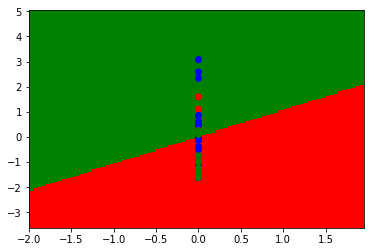

In [83]:
# Don't change these imports. Note that the last two are the
# class implementations that you will implement in
# LogisticRegression.py and GaussianNaiveBayes.py
import matplotlib.pyplot as plt
import pandas as pd
#from LogisticRegression import LogisticRegression
#from GaussianGenerativeModel import GaussianGenerativeModel


## These are the hyperparameters to the classifiers. You may need to
# adjust these as you try to find the best fit for each classifier.

# Logistic Regression parameters
eta = .5
lambda_parameter = 0


# Do not change anything below this line!!
# -----------------------------------------------------------------

# Read from file and extract X and Y
df = pd.read_csv("fruit.csv")
X = df[['width', 'height']].values
Y = (df['fruit'] - 1).values

#nb1 = GaussianGenerativeModel(isSharedCovariance=False)
#nb1.fit(X,Y)
#nb1.visualize("generative_result_separate_covariances.png")

#nb2 = GaussianGenerativeModel(isSharedCovariance=True)
#nb2.fit(X,Y)
#nb2.visualize("generative_result_shared_covariances.png")

lr = LogisticRegression(eta=eta, lambda_parameter=lambda_parameter)
lr.fit(X,Y)
lr.visualize('logistic_regression_result.png')

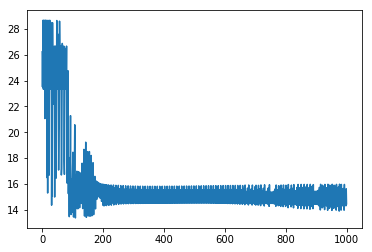

In [84]:
err = lr.errors
plt.plot(range(len(err)),err)

In [49]:
etas = [0.01,0.05,0.1,0.5,1,5]
lambdas = [0,0.1,0.5,1,5,10,50,100]
print etas
print lambdas

[0.01, 0.05, 0.1, 0.5, 1, 5]
[0, 0.1, 0.5, 1, 5, 10, 50, 100]


In [63]:
etas1 = np.array(range(100))/float(100)
etas1

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
        0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
        0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
        0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
        0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99])

In [64]:
eta_errs = []
for eta in etas1:
    reg1 = LogisticRegression(eta=eta, lambda_parameter=lamb)
    reg1.fit(X,Y)
    eta_errs.append(reg1.final_err)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in absolute
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in absolute


In [50]:
errs = []

for eta in etas:
    print "eta: ", eta
    lmb_errs = []
    for lamb in lambdas:
        print "lambda: ", lamb
        reg = LogisticRegression(eta=eta, lambda_parameter=lamb)
        reg.fit(X,Y)
        lmb_errs.append(reg.final_err)
    errs.append(lmb_errs)
        

eta:  0.01
lambda:  0
lambda:  0.1
lambda:  0.5
lambda:  1
lambda:  5
lambda:  10
lambda:  50
lambda:  100
eta:  0.05
lambda:  0
lambda:  0.1
lambda:  0.5
lambda:  1
lambda:  5
lambda:  10
lambda:  50
lambda:  100
eta:  0.1
lambda:  0
lambda:  0.1
lambda:  0.5
lambda:  1
lambda:  5
lambda:  10
lambda:  50
lambda:  100


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in absolute
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in absolute


eta:  0.5
lambda:  0
lambda:  0.1
lambda:  0.5
lambda:  1
lambda:  5
lambda:  10
lambda:  50
lambda:  100
eta:  1
lambda:  0
lambda:  0.1
lambda:  0.5
lambda:  1
lambda:  5
lambda:  10
lambda:  50
lambda:  100
eta:  5
lambda:  0
lambda:  0.1
lambda:  0.5
lambda:  1
lambda:  5
lambda:  10
lambda:  50
lambda:  100


In [53]:
errs[4]

[15.9086151303042,
 19.04661673010024,
 24.108175774755924,
 15.9086151303042,
 23.333421254708565,
 nan,
 nan,
 nan]

In [48]:
many_errs = errs

In [69]:
eta_errs

[26.222222222222211,
 26.022516058856791,
 26.022516058856791,
 25.004016485611242,
 23.87766743842575,
 23.367371749136655,
 23.333333333333332,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
plt.plot